In [ ]:
from collections import defaultdict, Counter
import json
from tqdm import tqdm
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
# --- 1. 기본 경로 및 파일 경로 설정 ---
base_dir = Path(os.getcwd()).resolve().parent
data_path = base_dir / "assets"

# 이미지와 어노테이션 정보를 저장할 각각의 Parquet 파일 경로
image_parquet_path = data_path / "images.parquet"
anno_parquet_path = data_path / "annotations.parquet"

# 카테고리 정보 로드
with (data_path / "categories.json").open("r", encoding="utf-8") as f:
    categories = json.load(f)

# --- 2. JSON 파일들을 순회하며 Parquet 파일에 점진적으로 추가 ---
image_writer = None
anno_writer = None

# tqdm으로 진행 상황 확인
for json_file in tqdm(data_path.glob("TL/TL_*_*/*.json"), desc="Processing JSON files"):
    with json_file.open("r", encoding="utf-8") as f:
        coco_data = json.load(f)
    
    # --- 이미지 데이터 처리 ---
    df_img = pd.DataFrame(coco_data.get('images', []))
    if not df_img.empty:
        # 메모리 절약을 위한 데이터 타입 최적화
        df_img['id'] = df_img['id'].astype('int32')
        df_img['width'] = df_img['width'].astype('int16')
        df_img['height'] = df_img['height'].astype('int16')
        
        # DataFrame을 Arrow Table로 변환
        img_table = pa.Table.from_pandas(df_img)
        
        if image_writer is None:
            # 첫 번째 chunk일 경우, 파일을 새로 쓰고 writer를 엽니다.
            image_writer = pq.ParquetWriter(image_parquet_path, img_table.schema)
        
        image_writer.write_table(img_table)

    # --- 어노테이션 데이터 처리 ---
    df_ann = pd.DataFrame(coco_data.get('annotations', []))
    if not df_ann.empty:
        # 메모리 절약을 위한 데이터 타입 최적화
        df_ann['id'] = df_ann['id'].astype('int32')
        df_ann['image_id'] = df_ann['image_id'].astype('int32')
        df_ann['category_id'] = df_ann['category_id'].astype('int16')
        df_ann['iscrowd'] = df_ann['iscrowd'].astype('bool')
        
        # DataFrame을 Arrow Table로 변환
        ann_table = pa.Table.from_pandas(df_ann)
        
        if anno_writer is None:
            # 첫 번째 chunk일 경우, 파일을 새로 쓰고 writer를 엽니다.
            anno_writer = pq.ParquetWriter(anno_parquet_path, ann_table.schema)
        
        anno_writer.write_table(ann_table)

# --- 3. 모든 파일 처리 후 Writer 닫기 ---
if image_writer:
    image_writer.close()
    print(f"\nImage data successfully saved to: {image_parquet_path}")

if anno_writer:
    anno_writer.close()
    print(f"Annotation data successfully saved to: {anno_parquet_path}")


# --- 4. 저장된 Parquet 파일 내용 확인 ---
print("\n--- Verifying saved files ---")

try:
    print("\n[Images DataFrame Head]")
    df_images_final = pd.read_parquet(image_parquet_path)
    print(df_images_final.head())
    print("\nImage Info:")
    df_images_final.info(memory_usage='deep')
except FileNotFoundError:
    print(f"File not found: {image_parquet_path}")

try:
    print("\n[Annotations DataFrame Head]")
    df_annotations_final = pd.read_parquet(anno_parquet_path)
    print(df_annotations_final.head())
    print("\nAnnotation Info:")
    df_annotations_final.info(memory_usage='deep')
except FileNotFoundError:
    print(f"File not found: {anno_parquet_path}")

/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43311 instead
  warnings.warn(


Dask Client 시작됨: http://127.0.0.1:43311/status
Dask DataFrame의 일부를 확인합니다 (실제 계산 발생):


/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 21.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


결과 데이터가 없습니다. (No annotations found)

전체 어노테이션 개수를 계산합니다 (실제 계산 발생):


/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 21.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Total valid annotations found: 0


2025-09-15 17:35:08,378 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bdf8e24d31632e558850cd4e5ec6235e initialized by task ('shuffle-transfer-bdf8e24d31632e558850cd4e5ec6235e', 9738) executed on worker tcp://127.0.0.1:45151
2025-09-15 17:38:01,471 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bdf8e24d31632e558850cd4e5ec6235e deactivated due to stimulus 'task-finished-1757925481.4662468'


images.parquet 파일을 성공적으로 불러왔습니다.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18422 entries, 0 to 18421
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             18422 non-null  int32 
 1   file_name      18422 non-null  object
 2   width          18422 non-null  int16 
 3   height         18422 non-null  int16 
 4   license        18422 non-null  int64 
 5   date_captured  18422 non-null  object
dtypes: int16(2), int32(1), int64(1), object(2)
memory usage: 575.8+ KB
None


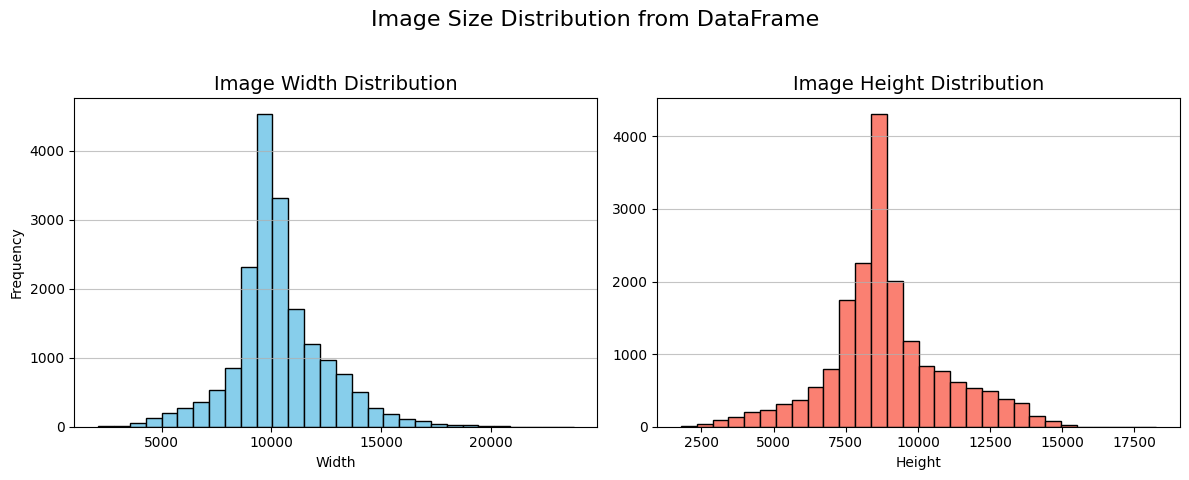

In [3]:
try:
    df_images = pd.read_parquet(image_parquet_path)
    print("images.parquet 파일을 성공적으로 불러왔습니다.")
    print(df_images.info())
except FileNotFoundError:
    print(f"오류: {image_parquet_path} 파일을 찾을 수 없습니다. 이전 단계가 정상적으로 완료되었는지 확인해주세요.")
    # 파일이 없으면 이후 코드를 실행할 수 없으므로 종료합니다.
    exit()

plt.figure(figsize=(12, 5))

# --- Image Width Distribution ---
plt.subplot(1, 2, 1)
# DataFrame의 'width' 컬럼을 직접 사용
plt.hist(df_images['width'], bins=30, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution', fontsize=14)
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


# --- Image Height Distribution ---
plt.subplot(1, 2, 2)
# DataFrame의 'height' 컬럼을 직접 사용
plt.hist(df_images['height'], bins=30, color='salmon', edgecolor='black')
plt.title('Image Height Distribution', fontsize=14)
plt.xlabel('Height')
# y-label은 왼쪽에만 있어도 충분하므로 생략 가능
# plt.ylabel('Frequency') 
plt.grid(axis='y', alpha=0.75)


plt.suptitle('Image Size Distribution from DataFrame', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitle과 겹치지 않도록 조절
plt.show()

images.parquet 파일을 성공적으로 불러왔습니다.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452103 entries, 0 to 452102
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           452103 non-null  int32  
 1   image_id     452103 non-null  int32  
 2   category_id  452103 non-null  int16  
 3   attributes   452103 non-null  object 
 4   iscrowd      452103 non-null  bool   
 5   area         452103 non-null  float64
 6   bbox         452103 non-null  object 
dtypes: bool(1), float64(1), int16(1), int32(2), object(2)
memory usage: 15.1+ MB
None


/tmp/ipykernel_13749/3865370.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')


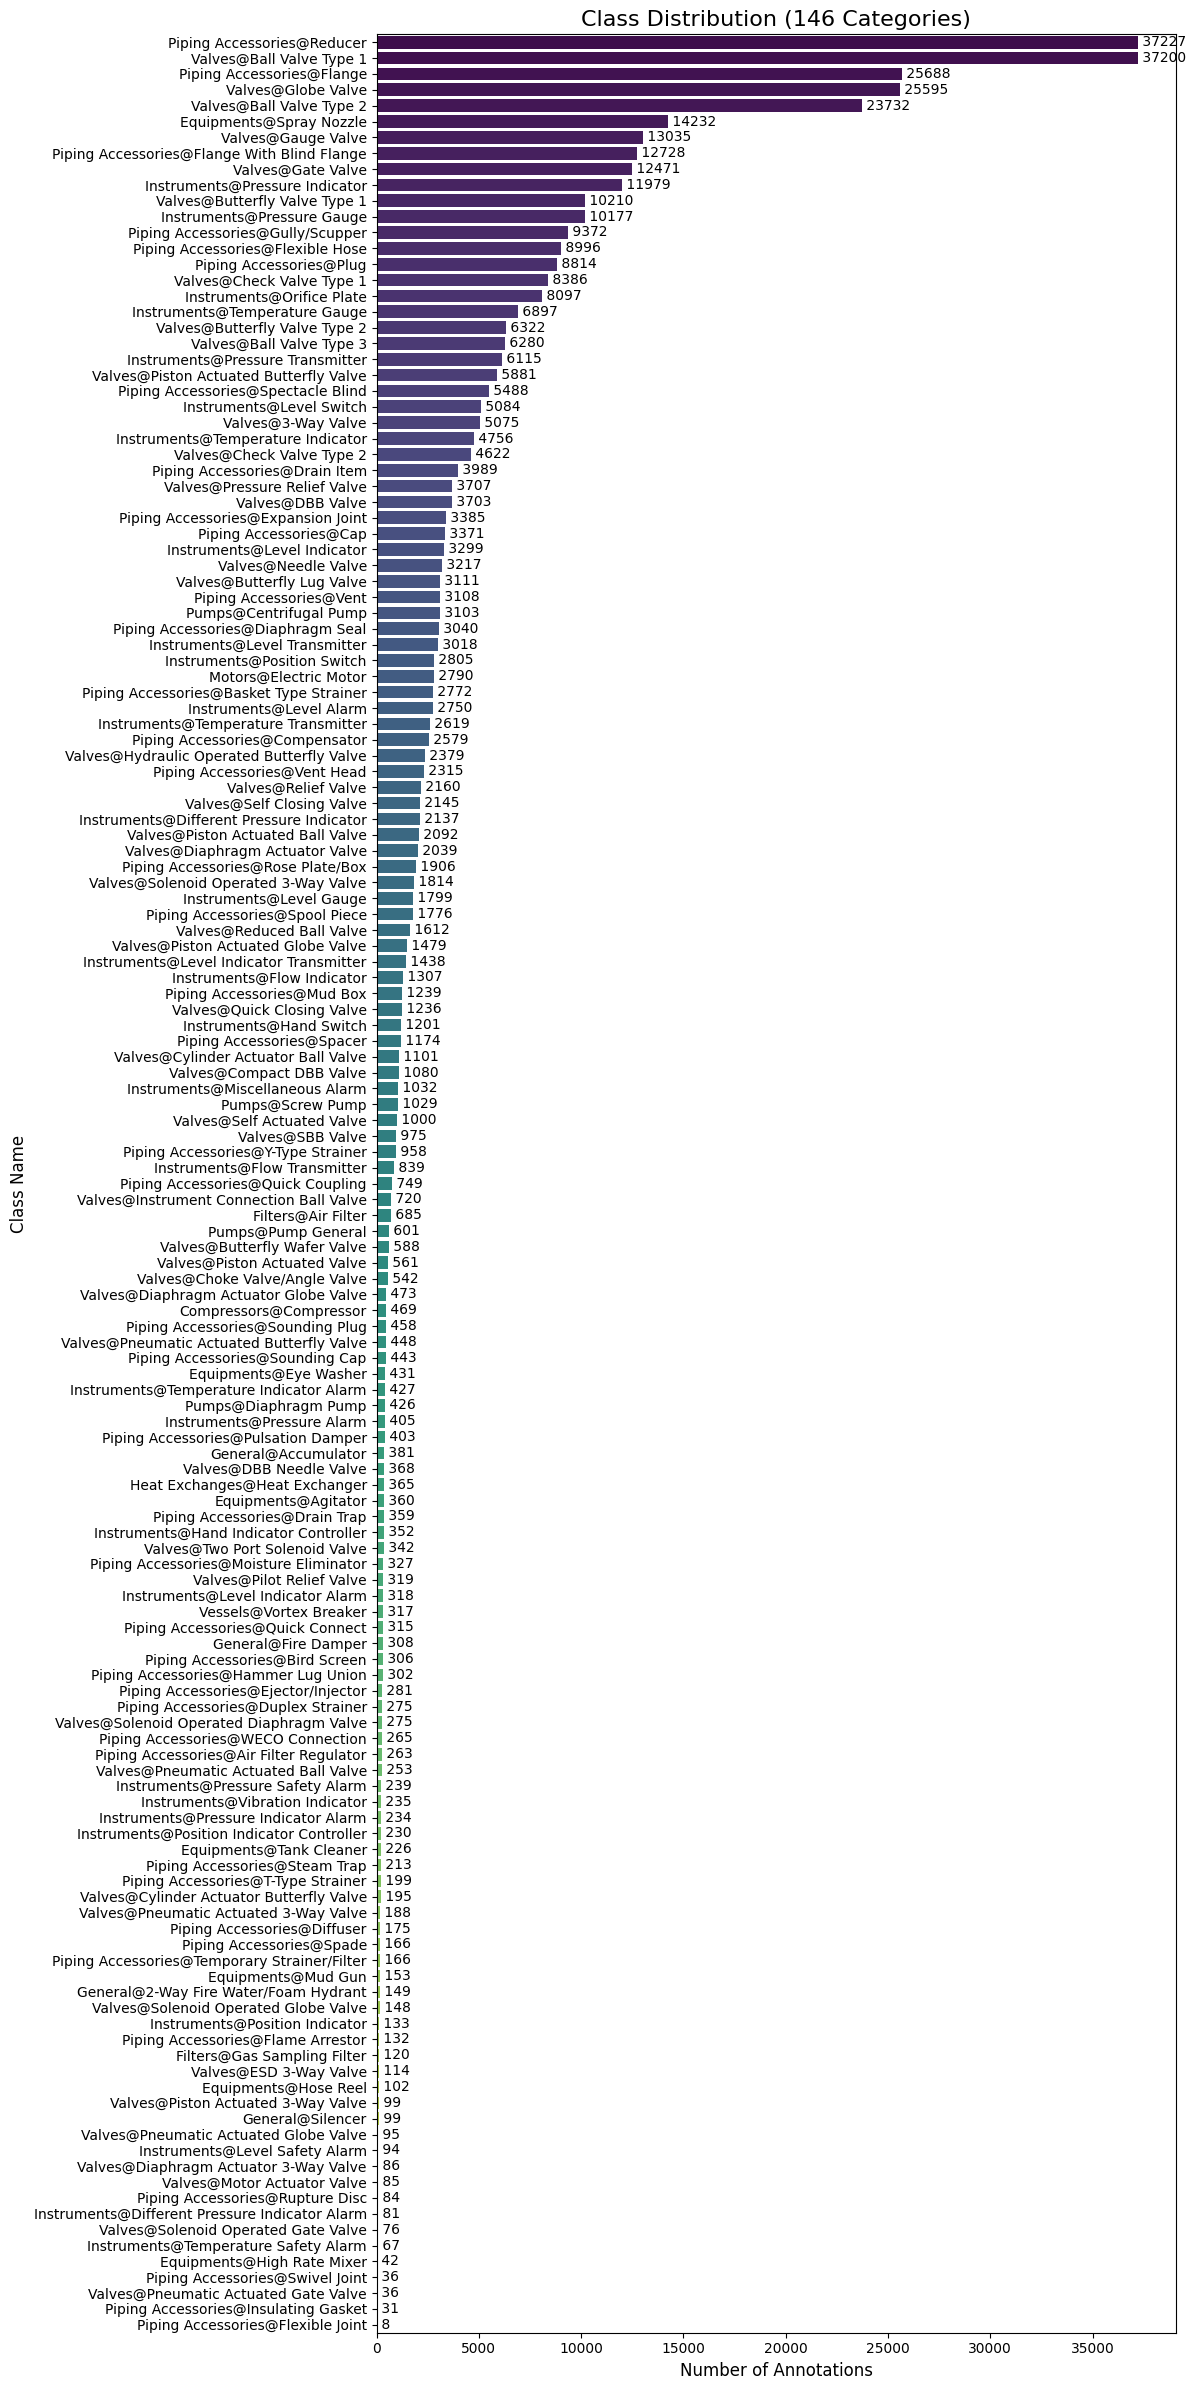

In [4]:
try:
    df_annotations = pd.read_parquet(anno_parquet_path)
    print("images.parquet 파일을 성공적으로 불러왔습니다.")
    print(df_annotations.info())
except FileNotFoundError:
    print(f"오류: {anno_parquet_path} 파일을 찾을 수 없습니다. 이전 단계가 정상적으로 완료되었는지 확인해주세요.")
    # 파일이 없으면 이후 코드를 실행할 수 없으므로 종료합니다.
    exit()

# --- 1. Pandas를 사용한 효율적인 클래스 집계 ---

# category_id를 기준으로 각 클래스의 어노테이션 수를 계산 (자동으로 내림차순 정렬)
class_counts = df_annotations['category_id'].value_counts()

# category_id -> name 매핑 딕셔너리 생성
category_map = {cat['id']: cat['name'] for cat in categories}

# 집계 결과(Series)의 인덱스(category_id)를 클래스 이름으로 변환
class_counts.index = class_counts.index.map(category_map)


# --- 2. 수평 막대그래프를 사용한 효과적인 시각화 ---

# 그래프 크기 조절 (클래스 수에 비례하여 세로 길이를 충분히 확보)
plt.figure(figsize=(12, 24)) 

# Seaborn을 사용하여 더 보기 좋은 수평 막대그래프 생성
# orient='h' 대신 x와 y를 바꿔주면 수평 그래프가 됩니다.
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')

# 그래프 제목 및 라벨 설정
plt.title('Class Distribution (146 Categories)', fontsize=16)
plt.xlabel('Number of Annotations', fontsize=12)
plt.ylabel('Class Name', fontsize=12)

# 각 막대에 개수 표시 (선택 사항)
for index, value in enumerate(class_counts.values):
    plt.text(value, index, f' {value}', va='center')

# 레이아웃을 타이트하게 조절
plt.tight_layout()
plt.show()

In [5]:
# --- 1. 벡터 연산을 통한 비율 계산 ---

# 전체 어노테이션 수를 구합니다.
total_annotations = class_counts.sum()

# 각 클래스의 백분율을 한 번에 계산합니다.
percentages = (class_counts / total_annotations) * 100


# --- 2. 보기 좋은 요약 DataFrame 생성 및 출력 ---

# 집계된 수와 백분율을 합쳐 새로운 DataFrame을 만듭니다.
df_summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage (%)': percentages
})

# --- 3. 최종 결과 출력 ---

# Pandas의 기본 출력 기능을 사용하여 깔끔하게 전체 결과를 보여줍니다.
print("--- Class Distribution Summary ---")

# 더 보기 좋게 출력 형식을 지정할 수 있습니다. (소수점 2자리)
# to_string()을 사용하면 전체 데이터가 잘리지 않고 출력됩니다.
print(df_summary.to_string(formatters={'Percentage (%)': '{:,.2f}%'.format}))

--- Class Distribution Summary ---
                                                Count Percentage (%)
category_id                                                         
Piping Accessories@Reducer                      37227          8.23%
Valves@Ball Valve Type 1                        37200          8.23%
Piping Accessories@Flange                       25688          5.68%
Valves@Globe Valve                              25595          5.66%
Valves@Ball Valve Type 2                        23732          5.25%
Equipments@Spray Nozzle                         14232          3.15%
Valves@Gauge Valve                              13035          2.88%
Piping Accessories@Flange With Blind Flange     12728          2.82%
Valves@Gate Valve                               12471          2.76%
Instruments@Pressure Indicator                  11979          2.65%
Valves@Butterfly Valve Type 1                   10210          2.26%
Instruments@Pressure Gauge                      10177          2.25%

In [6]:
# bbox 정보를 각각의 컬럼으로 분리
df_annotations[['x', 'y', 'w', 'h']] = pd.DataFrame(df_annotations['bbox'].tolist(), index=df_annotations.index)

display(df_annotations.head())

,id,image_id,category_id,attributes,iscrowd,area,bbox,x,y,w,h
0,1,1,1512,"{'pidLabel': 'PG', 'shipType': 'Fixed Platform...",False,76314.00,"[209.1, 4788.4, 276.5, 276.0]",209.1,4788.4,276.5,276.0
1,2,1,1512,"{'pidLabel': 'PG', 'shipType': 'Fixed Platform...",False,75706.80,"[1665.4, 4793.8, 276.0, 274.3]",1665.4,4793.8,276.0,274.3
2,3,1,1512,"{'pidLabel': 'PG', 'shipType': 'Fixed Platform...",False,76313.64,"[8176.7, 4788.4, 276.9, 275.6]",8176.7,4788.4,276.9,275.6
3,4,1,1512,"{'pidLabel': 'PG', 'shipType': 'Fixed Platform...",False,76784.37,"[9637.8, 4793.1, 276.9, 277.3]",9637.8,4793.1,276.9,277.3
4,5,1,1711,"{'pidLabel': '', 'shipType': 'Fixed Platform',...",False,220016.97,"[871.1, 5417.4, 782.7, 281.1]",871.1,5417.4,782.7,281.1


In [7]:
# 박스 크기(area) 계산
df_annotations['box_area'] = df_annotations['w'] * df_annotations['h']

# 박스 종횡비(aspect ratio) 계산 (0으로 나누는 오류 방지)
df_annotations['aspect_ratio'] = df_annotations['w'] / df_annotations['h'].replace(0, 1e-6) 

# 박스 중심점(spatial location) 계산
df_annotations['center_x'] = df_annotations['x'] + df_annotations['w'] / 2
df_annotations['center_y'] = df_annotations['y'] + df_annotations['h'] / 2

print("\n계산 완료:")
display(df_annotations[['box_area', 'aspect_ratio', 'center_x', 'center_y']].head())


계산 완료:


,box_area,aspect_ratio,center_x,center_y
0,76314.00,1.001812,347.35,4926.40
1,75706.80,1.006198,1803.40,4930.95
2,76313.64,1.004717,8315.15,4926.20
3,76784.37,0.998558,9776.25,4931.75
4,220016.97,2.784418,1262.45,5557.95


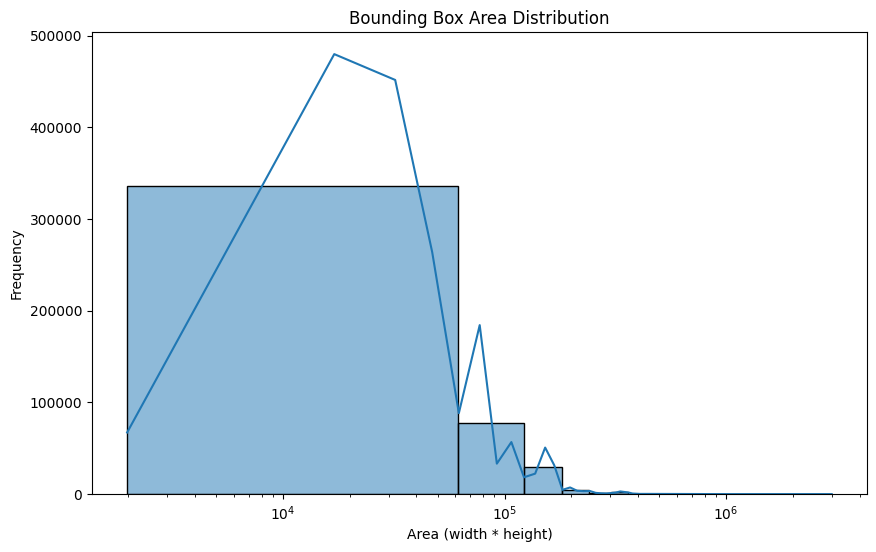

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_annotations['box_area'], bins=50, kde=True)
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (width * height)')
plt.ylabel('Frequency')
# x축을 로그 스케일로 보면 더 자세한 분포를 확인할 수 있습니다.
plt.xscale('log')
plt.show()

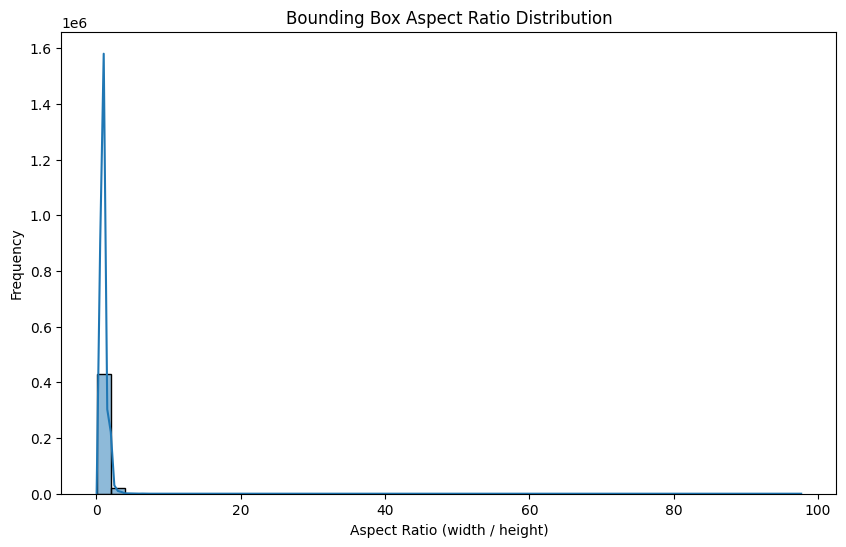

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_annotations['aspect_ratio'], bins=50, kde=True)
plt.title('Bounding Box Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frequency')
plt.show()

In [12]:
# --- 1. 데이터 병합: 각 어노테이션에 해당하는 이미지 크기 정보 추가 ---

# df_images에서 시각화에 필요한 컬럼만 선택하고, merge를 위해 'id' 컬럼 이름을 바꿉니다.
df_image_dims = pd.read_parquet(
    image_parquet_path, 
    columns=['id', 'width', 'height']
).rename(columns={'id': 'image_id'})

df_annotations_dims = pd.read_parquet(
    anno_parquet_path, 
    columns=['image_id', 'category_id', 'bbox']
)

# 'image_id'를 기준으로 두 DataFrame을 병합합니다.
df_merged = pd.merge(df_annotations, df_image_dims, on='image_id')


# --- 2. 정규화된 좌표 계산 ---

# 중심점 좌표를 각 이미지의 너비와 높이로 나누어 정규화합니다.
df_merged['norm_center_x'] = df_merged['center_x'] / df_merged['width']
df_merged['norm_center_y'] = df_merged['center_y'] / df_merged['height']


# --- 3. 정규화된 좌표 시각화 ---

# 이제 xlim, ylim을 고정된 (0, 1) 범위로 설정할 수 있습니다.
# 데이터 자체가 0과 1 사이이므로 xlim, ylim을 명시하지 않아도 됩니다.
sns.jointplot(x='norm_center_x', y='norm_center_y', data=df_merged, kind='hex', height=8)

plt.suptitle('Normalized Spatial Distribution of Bounding Box Centers', y=1.02)

# y축을 뒤집어 이미지 좌표계와 동일하게 만듭니다 (좌상단이 0,0).
plt.gca().invert_yaxis()
plt.show()

MemoryError: Unable to allocate 62.1 GiB for an array with shape (8328641466,) and data type int64

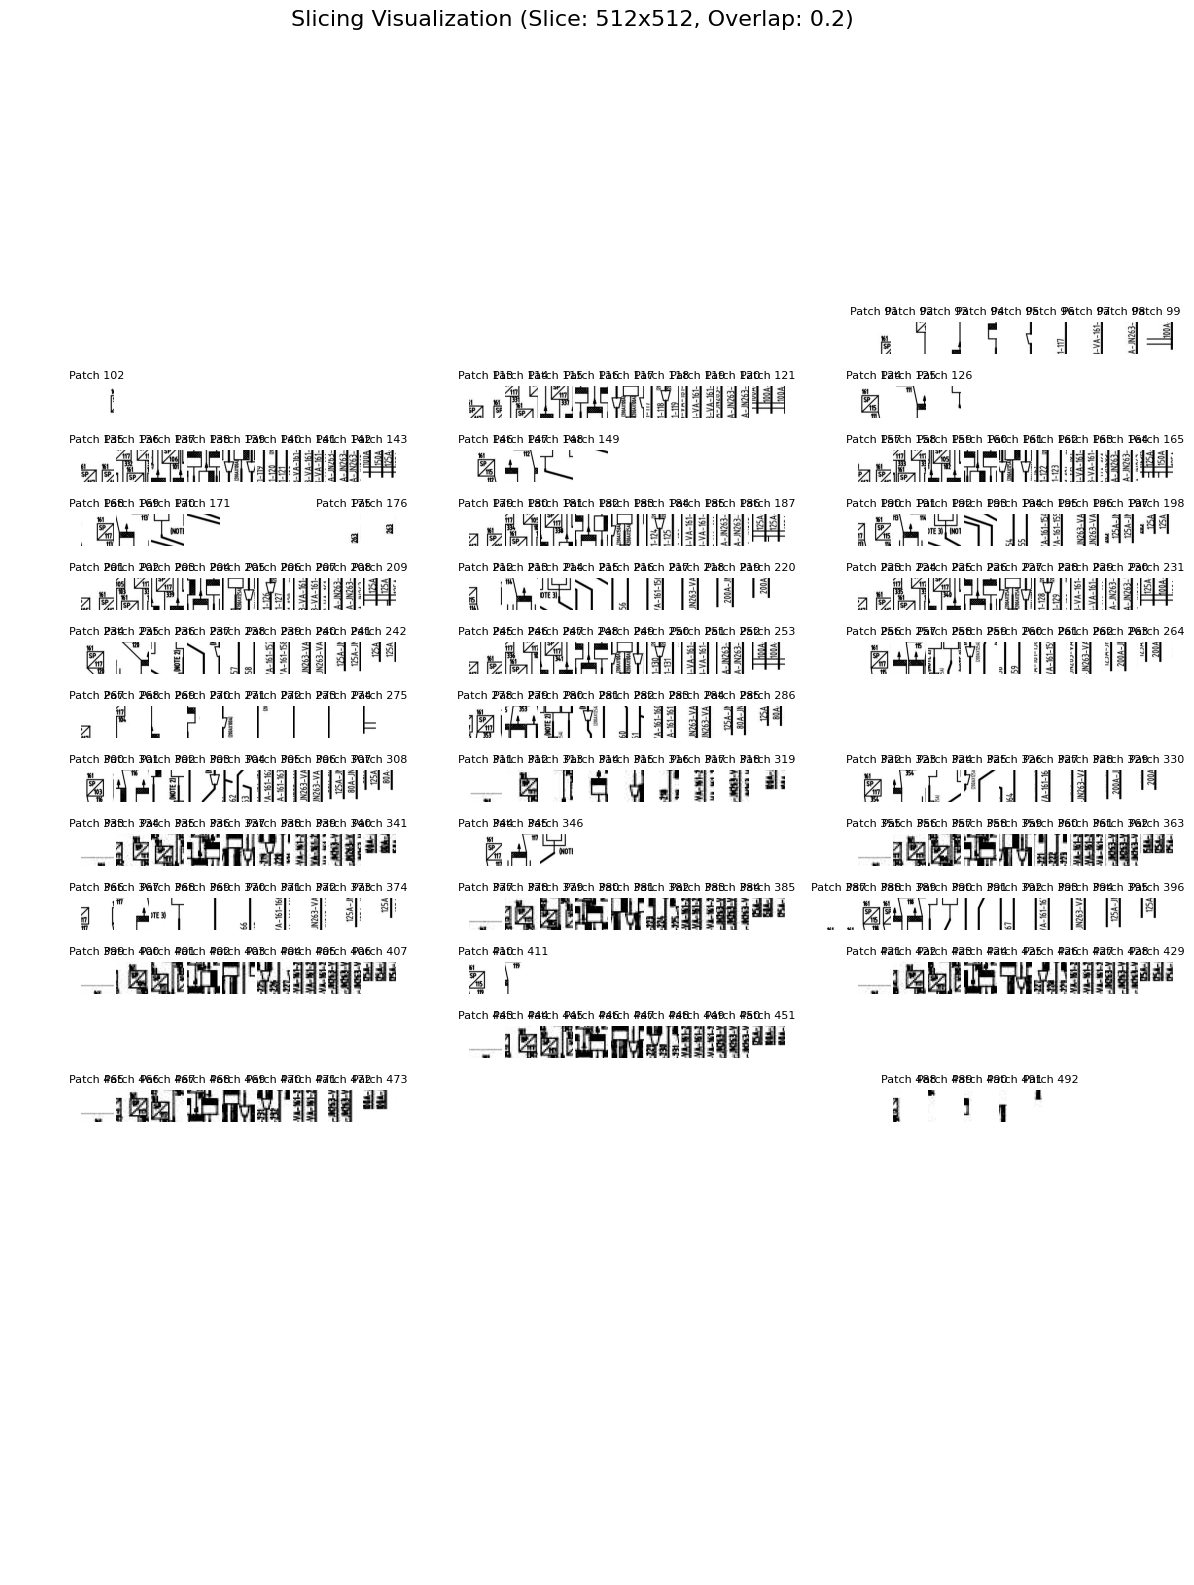

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def visualize_slicing_improved(image_path: Path, slice_height: int, slice_width: int, overlap_ratio: float = 0.2):
    """
    이미지를 슬라이싱하고 그 결과를 시각화하는 개선된 함수.
    - 중복 패치 생성 로직 수정
    - 시각화 시 제목 겹침 문제 해결
    - (선택) 비어있는 흰색 패치는 건너뛰어 시각화 효율 향상
    
    Args:
        image_path (Path): 입력 이미지 파일 경로.
        slice_height (int): 각 패치의 높이.
        slice_width (int): 각 패치의 너비.
        overlap_ratio (float): 패치 간의 중첩 비율.
    """
    # 1. 이미지 불러오기
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"오류: {image_path}에서 이미지를 불러올 수 없습니다.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img_rgb.shape

    # 2. 패치 좌표 계산
    overlap_h = int(slice_height * overlap_ratio)
    overlap_w = int(slice_width * overlap_ratio)
    
    # 패치 시작점(y, x) 목록 생성
    y_coords = np.arange(0, height, slice_height - overlap_h)
    x_coords = np.arange(0, width, slice_width - overlap_w)

    # 3. 패치 생성 (중복 방지 로직 적용)
    patches = []
    # 모든 좌표 조합에 대해 그리드 생성
    grid_coords = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)
    
    for x_start, y_start in grid_coords:
        # 경계를 벗어나는 패치의 시작점을 이미지 끝에 맞게 보정
        if y_start + slice_height > height:
            y_start = height - slice_height
        if x_start + slice_width > width:
            x_start = width - slice_width
            
        # 실제 패치 추출
        patch = img_rgb[y_start : y_start + slice_height, x_start : x_start + slice_width]
        patches.append(patch)
        
    # 중복된 패치 제거 (set을 이용)
    unique_patches_with_info = []
    seen_patches = set()
    
    patch_index = 0
    for x_start, y_start in grid_coords:
        patch_to_check = patches[patch_index].tobytes()
        if patch_to_check not in seen_patches:
            unique_patches_with_info.append({"patch": patches[patch_index], "index": patch_index + 1})
            seen_patches.add(patch_to_check)
        patch_index += 1


    # 4. 시각화 (제목 겹침 문제 해결)
    rows = len(y_coords)
    cols = len(x_coords)
    # figsize의 높이를 늘려 제목 공간 확보
    fig, axs = plt.subplots(rows, cols, figsize=(15, 18))
    axs = axs.flatten()
    
    patch_index = 0
    for i in range(len(axs)):
        # 모든 그리드 위치에 대해 처리
        if i < len(patches):
            patch = patches[i]
            # (선택 사항) 패치가 대부분 흰색(배경)이면 그리지 않음
            if np.mean(patch) > 250:
                 axs[i].axis('off')
                 continue

            axs[i].imshow(patch)
            axs[i].set_title(f"Patch {i+1}", fontsize=8)
        
        axs[i].axis('off')
        
    # 더 이상 사용하지 않는 축 삭제
    for i in range(len(patches), len(axs)):
        fig.delaxes(axs[i])

    plt.suptitle(f'Slicing Visualization (Slice: {slice_width}x{slice_height}, Overlap: {overlap_ratio})', fontsize=16)
    
    # tight_layout() 대신 subplots_adjust 사용하여 간격 수동 조절
    plt.subplots_adjust(hspace=0.5, wspace=0.1)
    
    plt.show()


try:
    image_path = data_path / "V01_04_006_001_1.png"
    visualize_slicing_improved(image_path, slice_height=512, slice_width=512, overlap_ratio=0.2)
except FileNotFoundError:
    print(f"이미지 파일을 찾을 수 없습니다. image_path 변수를 올바르게 설정해주세요.")
except NameError:
    print("image_path 변수가 정의되지 않았습니다. 실제 이미지 파일 경로로 설정해주세요.")
